In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

from itertools import repeat
from torch.multiprocessing import Pool
import time


from scipy.signal import find_peaks

def do_rollout_from_state(env, policy, init_state, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 1, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        #obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act = policy(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_explore_rollout(args):
    force, init_state, trial_num = args
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
    
    env.seed(trial_num)
    obs, acts, rews, x_list = do_push_rollout_from_state(env, policy, init_state, force)    
    
    return np.asarray(obs)

In [2]:
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short

seeds = [0,1,2,3,4,5,6,7,8,9]


env = gym.make(env_name)
data = torch.load(f"./data_noise1/{env_name}.xr")
#data = torch.load(f"./data17/{env_name}.xr")

init_policy_dict = data.policy_dict

data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
#data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

running build_ext


# Construct Initial Mesh

tensor(False)
2 poincare snapshots, 10 states in mesh


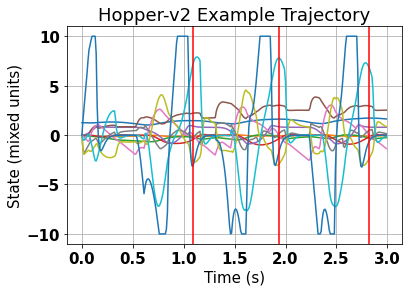

In [33]:
#normal_seed  = 6
#noise_seed = 0 or 8

from collections import namedtuple

class MeshBox:
    def __init__(self, state, iden, freq, trans_list):
        self.state = state
        self.id = iden
        self.freq = freq
        self.trans_list = trans_list

seed = 8; delta = .02;

policy = policy_dict[post_names[1]][seed]

mesh = BoxMesh(delta); mdim_l = []


fail_state = np.ones_like(env.reset())*100
fail_id = 0
mesh[fail_state] = MeshBox(fail_state, 0, 1, [])

obs, acts, rews, _ = do_long_rollout(env, policy, ep_length=1000)
peak_idx,_ = find_peaks(obs[:,0], distance=20)

        
for o in obs[peak_idx[2:],:]:
    key = (o - policy.state_means)/policy.state_std

    if key in mesh:
        mesh[key].freq +=1
    else:
        mesh[key] =  MeshBox(o, len(mesh), 1, [])
        

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

plt_idx = 300
plt.plot([.01*t for t in range(plt_idx)], obs[:plt_idx]);
peak_idx,_ = find_peaks(obs[:plt_idx,0], distance=20)

for i in peak_idx[1:]:
    plt.axvline(x=i*.01, color='r')

print(fail_cond(obs).any())
print(f"{len(peak_idx[2:])} poincare snapshots, {len(mesh)} states in mesh")

plt.title("Hopper-v2 Example Trajectory")
plt.xlabel('Time (s)')
plt.ylabel('State (mixed units)')
plt.grid()


# k_mat = np.zeros((len(mdim_mesh)-1,11))
# i = 0
# for box in list(mdim_mesh.values())[1:]:
#     k_mat[i,:] = box.state
#     i+=1

# from scipy.io import savemat
# savemat("./meshes/initial_poincare_states.mat",{"states":k_mat})

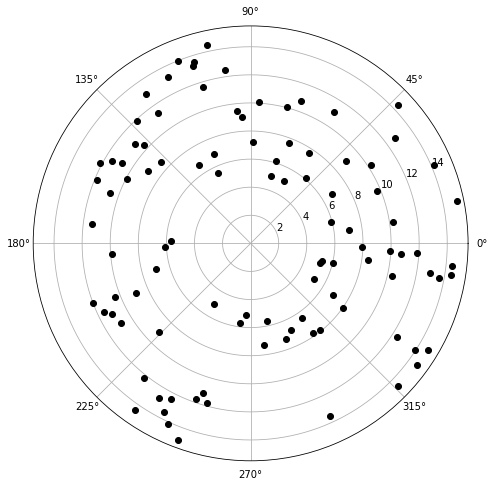

In [12]:
n_forces = 101

angs = np.random.uniform(0,2*np.pi,n_forces)
mags = np.random.uniform(5,15,n_forces) 
forces_x = np.cos(angs)*mags
forces_y = np.sin(angs)*mags

plt.figure(figsize=(8,8))
plt.polar(angs, mags, 'o',color='k')
#plt.xlabel('x')
#plt.ylabel('y')

force_iter = [np.array([fx,fy]) for fy,fx in zip(forces_x, forces_y)]

# plt.figure()
# plt.scatter(forces_x, forces_y)
# plt.aspect('equal')

In [13]:
start = time.time()
keys = list(mesh.keys())[1:]
i = 0 

with Pool() as pool:
    for init_key in keys:    
        i+=1 
        
        init_state = mesh[init_key].state
        state_iter = repeat(init_state, n_forces)
        seeds_iter = range(i*n_forces, i*n_forces+n_forces)

        for j, res in enumerate(pool.imap(do_explore_rollout, zip(force_iter, state_iter, seeds_iter))):
            obs = res
    
            peak_idx,_ = find_peaks(obs[:,0], distance=20)

            if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
                new_id = fail_id
                mesh[fail_state].freq +=1
            else:
                new_key = ((obs[peak_idx,:] - np.array(policy.state_means))/np.array(policy.state_std)).squeeze()
                if new_key in mesh:
                    new_id = mesh[new_key].id
                    mesh[new_key].freq += 1
                else:
                    mesh[new_key] = MeshBox(obs[peak_idx, :].squeeze(), len(mesh), 1, [])
                    new_id = len(mesh)-1
                    keys.append(mesh.__keytransform__(new_key))
            
            mesh[init_key].trans_list.append(new_id)
                        
                
        if i % 1000 == 0:
            print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

i; 1000, mdim: 1909, ratio: 0.5238344683080147
i; 2000, mdim: 2255, ratio: 0.8869179600886918
639.8159139156342


# Construct and Populate Transition Matrix

In [14]:
from scipy.sparse import lil_matrix
T = lil_matrix((len(mesh), len(mesh)))

T[0,0] = 1
for box in mesh.values():
    for trans_id in box.trans_list:
        T[box.id, trans_id] += 1/len(box.trans_list)

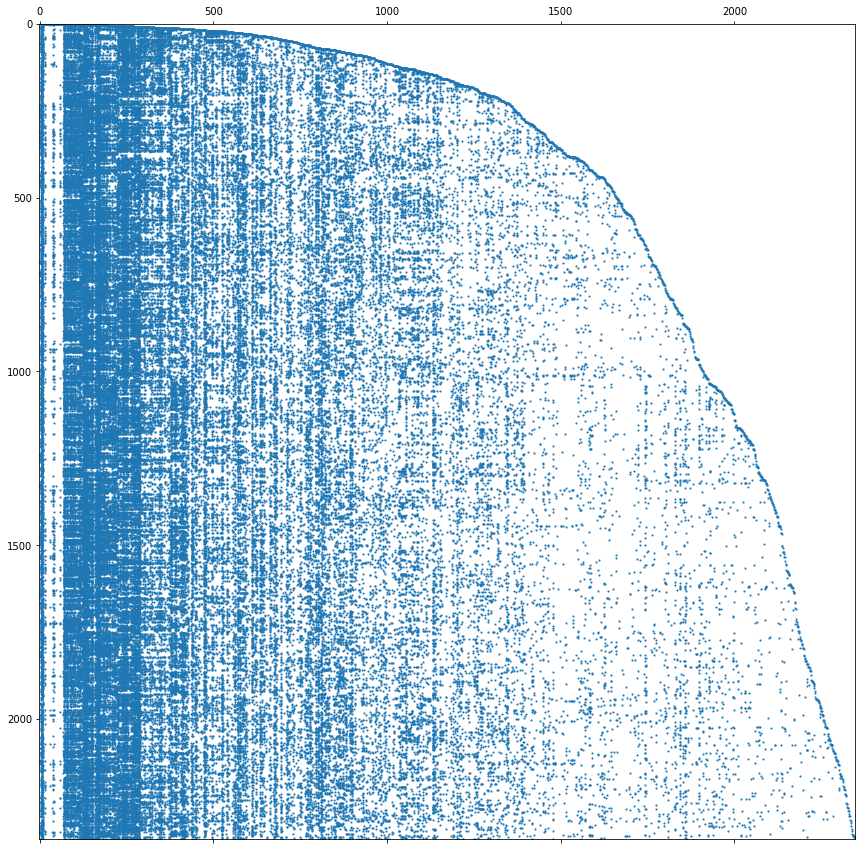

In [15]:
#plt.spy(T, markersize=4, figsize=(15,20))
fig, ax = plt.subplots(1, figsize=(15,15))
ax.spy(T, markersize=1)

In [16]:
from scipy.sparse.linalg import eigs
w, v = eigs(T.conjugate())
print(w)

print(-1/np.log(w[1]))

[ 1.        +0.j          0.98998217+0.j         -0.26740067+0.j
 -0.16146043-0.08160229j -0.16146043+0.08160229j  0.02498503-0.17551242j]
(99.3211377334452-0j)


In [17]:
import dill
with  open("meshes_f1/mdim0_noise.pkl", 'wb') as file:
   dill.dump(mesh, file)

/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [31]:
import dill
#with 
mdim_mesh = dill.load(open("meshes/hopper0_mdim_noise.pkl", 'rb'))
# with  open("meshes/hopper0_iden.pkl", 'wb') as file:
#   dill.dump(mdim_mesh, file)

In [17]:
T[:,0]

NameError: name 'T' is not defined

In [ ]:
box_size